In [1]:
import numpy as np
import time
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#### Instâncias e Demanda

In [2]:
def gerador_instancias(qtd_term,lim_inf_min,lim_inf_max,lim_sup_min,lim_sup_max,t_on_min,t_on_max,t_off_min,t_off_max,
                      custo_min,custo_max,periodos,demanda_min,demanda_max):

    lista_term = []
    df_term = pd.DataFrame()

    for t in range(qtd_term):
        lista_term.append(f'term_{t+1}')
    
    for term in lista_term:
        lim_inf = np.random.randint(lim_inf_min, lim_inf_max,1) ### Limite inferior da térmica
        lim_sup = np.random.randint(lim_sup_min,lim_sup_max,1) ### Limite superior da térmica
        t_on = np.random.randint(t_on_min,t_on_max,1) ### Tempo mínimo com térmica ligada
        t_off = np.random.randint(t_off_min,t_off_max,1) ### Tempo mínimo com térmica desligada
        custo = np.random.randint(custo_min,custo_max,1) ### Custo mínimo de geração de cada unidade de energia
        inf_term = {'termica':term,'limite_inferior': lim_inf, 'limite_superior': lim_sup,'t_on':t_on,'t_off':t_off,'custo':custo}
        df = pd.DataFrame(inf_term)
        df_term = pd.concat([df_term,df])

    demanda = np.random.randint(demanda_min,demanda_max,size=periodos)

    return df_term,demanda

In [23]:
df_term

,termica,limite_inferior,limite_superior,t_on,t_off,custo
0,term1,3,93,3,1,54
0,term2,3,89,3,1,85
0,term3,4,87,3,1,57
0,term4,2,86,2,3,80
0,term5,4,82,2,2,89


In [16]:
### Geração da Demanda

size = 500 ### Unidades de tempo total

demanda = np.random.randint(80,250,size=size)

In [56]:
#np.savetxt("demanda.csv", demanda, delimiter=",")

In [7]:
demanda = np.loadtxt("demanda.csv")

### Método Guloso

In [25]:
#df_term.to_csv("df_term.csv")

In [8]:
df_term = pd.read_csv("df_term.csv").drop(columns="Unnamed: 0")

In [59]:
df_term.sort_values('custo')

,termica,limite_inferior,limite_superior,t_on,t_off,custo
0,term1,2,83,2,3,55
3,term4,4,82,2,1,70
2,term3,3,80,3,1,73
4,term5,1,94,1,3,81
1,term2,3,99,1,1,83


In [3]:
def termicas_guloso(df_terms,demanda,size):

    total_tempo = len(demanda)
    colunas = list(df_terms.termica.unique()) ### Térmicas
    colunas_demanda = list(map(lambda item: 'demanda_' + item, colunas)) ### Demanda utilizada de cada térmica em cada tempo
    colunas_ton = list(map(lambda item: 'tempo_ligada_' + item, colunas))
    colunas_toff = list(map(lambda item: 'tempo_desligada_' + item, colunas)) ### Tempo que cada térmica está desligada
    colunas.extend(colunas_demanda)
    colunas.extend(colunas_ton)
    colunas.extend(colunas_toff)
    colunas.extend(['tempo','demanda','custo'])
    df_tempo = pd.DataFrame(columns=colunas,index=range(size)) ### Tabela final com os resultados de cada período de tempo
    df_terms_ordenado = df_terms.sort_values('custo') ### Ordenamento por melhor custo
    lista_termicas_ligadas = []

    ### Iteração para cada período de tempo
    for tempo in range(total_tempo):

        demanda_temp = 0
        custo = 0
        demanda_atual = demanda[tempo]

        if(tempo == 0): ### Condição especial quando o tempo é igual a zero e nenhuma térmica foi acionada ou deve permanecer desligada
            for term in range(len(df_terms_ordenado)): ### Iteração para cada térmica em cada período de tempo
                limite_superior = df_terms_ordenado.limite_superior.iloc[term]
                limite_inferior = df_terms_ordenado.limite_inferior.iloc[term]
                custo_term = df_terms_ordenado.custo.iloc[term]
                termica = df_terms_ordenado.termica.iloc[term]
                t_on = df_terms_ordenado.t_on.iloc[term]
                t_off = df_terms_ordenado.t_off.iloc[term]
                df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = t_off
                df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = 0
            
                if(((limite_superior+demanda_temp)>demanda_atual) and ## Demanda atual é inferior a soma do limite superior e a demanda já preenchida
                (demanda_temp != demanda_atual) and 
                ((demanda_atual-demanda_temp)>=limite_inferior)):
                    demanda_utilizada = demanda_atual-demanda_temp
                    custo = custo + (custo_term*demanda_utilizada)
                    demanda_temp = demanda_temp+demanda_utilizada
                    df_tempo.iloc[tempo][termica] = 1
                    df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada
                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0 
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = 1
                    print("Térmica acionada: ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp,
                          "Tempo: ",tempo,"Custo: ",custo,"Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])
                    
                elif((demanda_temp<demanda_atual) and ## Demanda preenchida é maior que limite inferior
                ((demanda_atual-demanda_temp)>=limite_inferior)):
                    demanda_utilizada = limite_superior
                    custo = custo+(custo_term*demanda_utilizada)
                    demanda_temp = demanda_temp+demanda_utilizada
                    df_tempo.iloc[tempo][termica] = 1
                    df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada
                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = 1
                    print("Térmica acionada: ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp, 
                          "Tempo: ",tempo,"Custo: ",custo,"Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])
                
                else: ### Térmica não foi acionada
                    df_tempo.iloc[tempo][termica] = 0
                    df_tempo.iloc[tempo][f'demanda_{termica}'] = 0

                if((df_tempo.iloc[tempo][f'tempo_ligada_{termica}']<t_on) and (df_tempo.iloc[tempo][f'tempo_ligada_{termica}']>0)):
                    lista_termicas_ligadas.append(termica)
            
            if(demanda_atual-demanda_temp!=0): ### Não foi possível encontrar uma combinação para atender a demanda
                return print("PROBLEMA IMPOSSÍVEL DE RESOLVER!!")
       
        ### Demais períodos de tempo
        else: 

            ### Térmicas que devem ser obrigatoriamente ligadas nesse período de tempo
            for term_ligada in lista_termicas_ligadas:

                df_term_ligada = df_terms_ordenado.loc[(df_terms_ordenado.termica==term_ligada)]
                limite_inferior = df_term_ligada.limite_inferior.iloc[0]
                custo_term = df_term_ligada.custo.iloc[0]
                termica = df_term_ligada.termica.iloc[0]
                
                demanda_utilizada = limite_inferior
                demanda_temp = demanda_temp + demanda_utilizada
                custo = custo + (custo_term*demanda_utilizada)
                df_tempo.iloc[tempo][termica] = 1
                df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada
                df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0
                df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = df_tempo.iloc[tempo-1][f'tempo_ligada_{termica}'] + 1

                print("Térmica acionada (Obrigatória): ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp, 
                      "Demanda Utilizada: ",demanda_utilizada,"Tempo: ",tempo,"Custo: ",custo,"Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])
                
            lista_termicas_ligadas = []

            df_temporario = pd.DataFrame(columns=['termica','demanda','limite_inferior','custo'])
            
            for term in range(len(df_terms_ordenado)): ### Iteração para cada térmica em cada período de tempo
                
                limite_superior = df_terms_ordenado.limite_superior.iloc[term]
                limite_inferior = df_terms_ordenado.limite_inferior.iloc[term]
                custo_term = df_terms_ordenado.custo.iloc[term]
                termica = df_terms_ordenado.termica.iloc[term]
                t_on = df_terms_ordenado.t_on.iloc[term]
                t_off = df_terms_ordenado.t_off.iloc[term]
                tempo_ligada = df_tempo.iloc[tempo-1][termica]
                tempo_desligada = df_tempo.iloc[tempo-1][f'tempo_desligada_{termica}']

                ## Delimita demanda disponível na térmica, caso já tenha sido utilizado demanda obrigatória
                if(df_tempo.iloc[tempo][f'demanda_{termica}']>0):
                    demanda_disponivel_termica = limite_superior - df_tempo.iloc[tempo][f'demanda_{termica}']
                else:
                    demanda_disponivel_termica = limite_superior

                ## Demanda atual é inferior a soma do limite superior e a demanda já preenchida
                if(((demanda_disponivel_termica+demanda_temp)>demanda_atual) and 
                    (demanda_temp != demanda_atual) and 
                    ((demanda_atual-demanda_temp)>=limite_inferior) and
                    ((tempo_desligada>=t_off) or (tempo_desligada==0))):
                    
                    demanda_utilizada = demanda_atual-demanda_temp
                    custo = custo + (custo_term*demanda_utilizada)
                    demanda_temp = demanda_temp+demanda_utilizada
                    df_tempo.iloc[tempo][termica] = 1
                    
                    if(df_tempo.iloc[tempo][f'demanda_{termica}']>0):
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = df_tempo.iloc[tempo][f'demanda_{termica}'] + demanda_utilizada
                    else:
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada
                        
                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0 
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = df_tempo.iloc[tempo-1][f'tempo_ligada_{termica}'] + 1
                    df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                           'demanda':df_tempo.iloc[tempo][f'demanda_{termica}'],
                                                                           'custo':custo_term},index=[1])])
                    print("Térmica acionada: ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp,
                          "Demanda Utilizada: ",demanda_utilizada,"Tempo: ",tempo,"Custo: ",custo,"Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])
                
                ## Demanda preenchida é maior que limite inferior
                elif((demanda_temp<demanda_atual) and 
                    ((demanda_atual-demanda_temp)>=limite_inferior) and
                    ((tempo_desligada>=t_off) or (tempo_desligada==0))):
                    
                    demanda_utilizada = demanda_disponivel_termica
                    custo = custo+(custo_term*demanda_utilizada)
                    demanda_temp = demanda_temp+demanda_utilizada
                    df_tempo.iloc[tempo][termica] = 1
                    
                    if(df_tempo.iloc[tempo][f'demanda_{termica}']>0):
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = df_tempo.iloc[tempo][f'demanda_{termica}'] + demanda_utilizada
                    else:
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada

                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0 
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = df_tempo.iloc[tempo-1][f'tempo_ligada_{termica}'] + 1
                    df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                           'demanda':df_tempo.iloc[tempo][f'demanda_{termica}'],
                                                                           'custo':custo_term},index=[1])])
                    print("Térmica acionada: ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp, 
                          "Demanda Utilizada: ",demanda_utilizada,"Tempo: ",tempo,"Custo: ",custo,"Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])

                ### Demanda restante é menor que o limite inferior
                elif((demanda_temp<demanda_atual) and 
                     (demanda_atual-demanda_temp<limite_inferior) and
                     ((tempo_desligada>=t_off) or (tempo_desligada==0))):
                    
                    demanda_excedida = limite_inferior - (demanda_atual-demanda_temp)
                    demanda_utilizada = limite_inferior
                    demanda_temp = demanda_temp-demanda_excedida+demanda_utilizada

                    pior_termica = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['termica'].iloc[0]
                    limite_inferior_pior_termica = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['limite_inferior'].iloc[0]

                    if(df_tempo.iloc[tempo][f'demanda_{pior_termica}']>=(demanda_excedida+limite_inferior_pior_termica)):
                        pior_custo = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['custo'].iloc[0]
                        df_tempo.iloc[tempo][f'demanda_{pior_termica}'] = df_tempo.iloc[tempo][f'demanda_{pior_termica}']-demanda_excedida
                    
                    custo = custo + (custo_term*demanda_utilizada) - (pior_custo*demanda_excedida)
                    df_tempo.iloc[tempo][termica] = 1
                    if(df_tempo.iloc[tempo][f'demanda_{termica}']>0):
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = df_tempo.iloc[tempo][f'demanda_{termica}'] + demanda_utilizada
                    else:
                        df_tempo.iloc[tempo][f'demanda_{termica}'] = demanda_utilizada
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = df_tempo.iloc[tempo-1][f'tempo_ligada_{termica}'] + 1
                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = 0
                    print("Térmica acionada: ",termica,"Demanda atual: ",demanda_atual,"Demanda temp: ",demanda_temp, 
                          "Demanda Utilizada: ",demanda_utilizada,"Tempo: ",tempo,"Custo: ",custo,
                          "Tempo acionada: ",df_tempo.iloc[tempo][f'tempo_ligada_{termica}'])

                if(df_tempo.iloc[tempo][termica]!=1): ### Térmica não foi acionada
                    df_tempo.iloc[tempo][termica] = 0
                    df_tempo.iloc[tempo][f'demanda_{termica}'] = 0
                    df_tempo.iloc[tempo][f'tempo_ligada_{termica}'] = 0
                    df_tempo.iloc[tempo][f'tempo_desligada_{termica}'] = df_tempo.iloc[tempo-1][f'tempo_desligada_{termica}']+1

                if((df_tempo.iloc[tempo][f'tempo_ligada_{termica}']<t_on) and (df_tempo.iloc[tempo][f'tempo_ligada_{termica}']>0)):
                    lista_termicas_ligadas.append(termica)
                    #print(lista_termicas_ligadas)

            if(demanda_atual-demanda_temp!=0): ### Não foi possível encontrar uma combinação para atender a demanda
                return print("PROBLEMA IMPOSSÍVEL DE RESOLVER!!")
                    
 
        df_tempo.iloc[tempo]['tempo'] = tempo
        df_tempo.iloc[tempo]['demanda'] = demanda[tempo]
        df_tempo.iloc[tempo]['custo'] = custo
    
    return df_tempo

In [23]:
df_termicas = termicas_guloso(df_term,demanda,size = len(demanda))

Térmica acionada:  term1 Demanda atual:  109.0 Demanda temp:  83 Tempo:  0 Custo:  4565 Tempo acionada:  1
Térmica acionada:  term4 Demanda atual:  109.0 Demanda temp:  109.0 Tempo:  0 Custo:  6385.0 Tempo acionada:  1
Térmica acionada (Obrigatória):  term1 Demanda atual:  153.0 Demanda temp:  2 Demanda Utilizada:  2 Tempo:  1 Custo:  110 Tempo acionada:  2
Térmica acionada (Obrigatória):  term4 Demanda atual:  153.0 Demanda temp:  6 Demanda Utilizada:  4 Tempo:  1 Custo:  390 Tempo acionada:  2
Térmica acionada:  term1 Demanda atual:  153.0 Demanda temp:  87 Demanda Utilizada:  81 Tempo:  1 Custo:  4845 Tempo acionada:  2
Térmica acionada:  term4 Demanda atual:  153.0 Demanda temp:  153.0 Demanda Utilizada:  66.0 Tempo:  1 Custo:  9465.0 Tempo acionada:  2
Térmica acionada:  term1 Demanda atual:  249.0 Demanda temp:  83 Demanda Utilizada:  83 Tempo:  2 Custo:  4565 Tempo acionada:  3
Térmica acionada:  term4 Demanda atual:  249.0 Demanda temp:  165 Demanda Utilizada:  82 Tempo:  2 Cus

In [24]:
df_termicas.custo.sum()

5157293.0

In [259]:
df_term.sort_values('custo')

,termica,limite_inferior,limite_superior,t_on,t_off,custo
0,term1,2,83,2,3,55
3,term4,4,82,2,1,70
2,term3,3,80,3,1,73
4,term5,1,94,1,3,81
1,term2,3,99,1,1,83


In [248]:
df_termicas.to_excel('df_termicas_02112025.xlsx',index=False)
df_termicas.to_csv('Resultado_02112025.csv',index=False)

In [235]:
#resultado = pd.read_csv('Resultado_02112025.csv')

In [314]:
#resultado.custo.sum()

### Teste de Solução Viável

In [4]:
def solucao_viavel(df_resultado,df_regras):

    termicas = list(df_regras.termica.unique()) ### Térmicas

    ### Iteração para veriricar em cada período de tempo se a combinação de térmicas ligadas atende os requisitos
    for tempo in range(len(df_resultado)):
        
        demanda = df_resultado.iloc[tempo]['demanda'] ### Demanda de cada tempo
        soma_limite_superior = 0

        ### Condição para o tempo zero, quando não existe restrição de t_on e t_off
        if tempo == 0:
            ### Iteração para cada térmica que foi ligada ou desligada
            for term in termicas:
                if df_resultado.iloc[tempo][term]==1:
                    soma_limite_superior = soma_limite_superior+df_regras.loc[(df_regras.termica==term)]['limite_superior'].iloc[0]
        
        ### Demais tempos, seguindo as restrições
        else:
            for term in termicas:
                if df_resultado.iloc[tempo][term]==1:
                    
                    soma_limite_superior = soma_limite_superior+df_regras.loc[(df_regras.termica==term)]['limite_superior'].iloc[0]
                    t_off = df_regras.loc[(df_regras.termica==term)]['t_off'].iloc[0]
                    estava_desligado = df_resultado.iloc[tempo-1][f'tempo_desligada_{term}']

                    ### Verifica se a térmica poderia estar ligada, atendendo as restrições de t_off
                    if estava_desligado<t_off and estava_desligado!=0:
                        #print("Térmica: ",term," no tempo: ",tempo," está desligada a: ",estava_desligado,
                        #      " períodos e deveria permanecer desligada a: ",t_off," períodos")
                        return False

                else:
                    
                    t_on = df_regras.loc[(df_regras.termica==term)]['t_on'].iloc[0]
                    estava_ligado = df_resultado.iloc[tempo-1][f'tempo_ligada_{term}']

                    ### Verifica se a térmica poderia estar desligada, atendendo as restrições de t_on
                    if estava_ligado<t_on and estava_ligado!=0:
                        #print("Térmica: ",term," no tempo: ",tempo," está ligada a: ",estava_ligado,
                        #      " períodos e deveria permacenecer ligada a: ",t_on," períodos")
                        return False

        ### Verifica se a soma dos limites superiores de cada térmica atende a demanda
        if soma_limite_superior<demanda:
            #print("Soma dos limites superiores das térmicas acionadas no tempo: ",tempo," é igual a: ",soma_limite_superior,
            #  " e a demanda é de: ",demanda) 
            return False

    return True              

In [315]:
#solucao_viavel(df_termicas_teste,df_term)

In [143]:
df_teste = pd.DataFrame({"Termica1":[0,1,0,1],"Termica2":[0,0,0,0],"Termica3":[1,0,1,0],"Termica4":[1,1,1,1]})

In [144]:
df_teste

,Termica1,Termica2,Termica3,Termica4
0,0,0,1,1
1,1,0,0,1
2,0,0,1,1
3,1,0,0,1


### Busca Local

In [5]:
def busca_local(df_resultado,df_regras,max): ### Busca local com parada em máximo de iterações

    termicas = list(df_regras.termica.unique())
    df_regras_ordenado = df_regras.sort_values('custo')
    termicas_ordenadas_melhor_custo = df_regras_ordenado.termica.unique()
    df_melhor_vizinho = df_resultado.copy()
    i=0
    max_it = 0
    lista_resultado = list(df_resultado.index)
    random.shuffle(termicas)
    custo_total = df_resultado.custo.sum()

    for term in termicas:
        for tempo in lista_resultado:
            df_novo_vizinho = df_melhor_vizinho.copy()
            for tempo2 in lista_resultado:
                if tempo!=tempo2:
            
                    demanda = df_resultado.iloc[tempo2]['demanda']
                    
                    if df_novo_vizinho.iloc[tempo2][term]==1:
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(term)] = 0
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{term}')] = 0
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 0
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = df_novo_vizinho.iloc[tempo2-1,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] + 1
                    else:
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(term)]=1
                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 0
                        df_novo_vizinho.iloc[tempo2-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = df_novo_vizinho.iloc[tempo2-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] + 1

                    #print("Térmica: ",term," ",np.array(df_novo_vizinho[term]))

                    for tempos in range(len(df_resultado)):
                        if tempos>0:
                            if df_novo_vizinho.iloc[tempos][term] == 0:
                                df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 0
                                df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = df_novo_vizinho.iloc[tempos-1,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')]+1
                            else:
                                df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = df_novo_vizinho.iloc[tempos-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')]+1
                                df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 0

                    if(solucao_viavel(df_novo_vizinho,df_regras)):
        
                        print("Solução viável encontrada no tempo: ",tempo2,",mudança na térmica: ",term," na iteração :",i)
                        demanda_utilizada = 0
                        demanda_temp = 0
                        custo = 0
                        df_temporario = pd.DataFrame(columns=['termica','demanda','limite_inferior','custo'])
                
                        for termica in termicas_ordenadas_melhor_custo:
        
                            if(df_novo_vizinho.iloc[tempo2][termica]==1):
                                
                                limite_superior = df_regras.loc[(df_regras.termica==termica)].limite_superior.iloc[0]
                                limite_inferior = df_regras.loc[(df_regras.termica==termica)].limite_inferior.iloc[0]
                                custo_term = df_regras.loc[(df_regras.termica==termica)].custo.iloc[0]
            
                                if((demanda_temp+limite_superior)<=demanda):
                                    demanda_utilizada = limite_superior
                                    demanda_temp = demanda_temp + demanda_utilizada
                                    custo = custo + (demanda_utilizada*custo_term)
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc('custo')] = custo
                                    df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                                   'demanda':df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])
    
                                elif((demanda_temp+limite_superior>demanda) and (demanda_temp+limite_inferior<=demanda)):
                                    demanda_utilizada = demanda - demanda_temp
                                    demanda_temp = demanda_temp + demanda_utilizada
                                    custo = custo + (demanda_utilizada*custo_term)
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc('custo')] = custo
                                    df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                                   'demanda':df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])
    
                                else:
                                    demanda_excedida = limite_inferior - (demanda-demanda_temp)
                                    demanda_utilizada = limite_inferior
                                    demanda_temp = demanda_temp-demanda_excedida+demanda_utilizada
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                      
                                    df_temporario.custo = df_temporario.custo.astype('int64')
                                    pior_termica = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['termica'].iloc[0]
                                    limite_inferior_pior_termica = df_temporario.loc[df_temporario.custo==\
                                                                   df_temporario.custo.max()]['limite_inferior'].iloc[0]
                                    
                                    if(df_novo_vizinho.iloc[tempo2][f'demanda_{pior_termica}']>=(demanda_excedida+limite_inferior_pior_termica)):
                                        pior_custo = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['custo'].iloc[0]
                                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] = \
                                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
                                    else:
                                        pior_termica = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['termica'].iloc[0]
                                        limite_inferior_pior_termica = df_temporario.loc[(df_temporario.custo==\
                                                                       df_temporario.custo.nlargest().iloc[1])]['limite_inferior'].iloc[0]
                                        pior_custo = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['custo'].iloc[0]
                                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] = \
                                        df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
        
                                    custo = custo + (custo_term*demanda_utilizada) - (pior_custo*demanda_excedida)
                                    df_novo_vizinho.iloc[tempo2,df_novo_vizinho.columns.get_loc('custo')] = custo
                        
                            i=i+1
                            max_it=max_it+1
                            #print("Max It = ",max_it)
                            
                            if(max_it>=max):
                                if(df_melhor_vizinho.custo.sum()<custo_total):
                                    return df_melhor_vizinho
                                else:
                                    print("Não foi encontrado uma solução melhor!")
                                    return df_resultado
                    
                        if df_novo_vizinho.custo.sum() < custo_total:
                            print("Foi encontrado uma solução melhor!")
                            print("Solução melhor encontrada no tempo: ",tempo2,"mudança na térmica: ",term," custo atual: ",df_novo_vizinho.custo.sum(),
                                  " custo anterior:",custo_total)
                            custo_total = df_melhor_vizinho.custo.sum()
                            max_it = 0
                            df_melhor_vizinho = df_novo_vizinho.copy()
                            return df_melhor_vizinho
                        
                    else:    
                        i=i+1
                        max_it = max_it+1
                    
                    if(max_it>=max):
                            if(df_melhor_vizinho.custo.sum()<df_resultado.custo.sum()):
                                return df_melhor_vizinho
                            else:
                                print("Não foi encontrado uma solução melhor!!")
                                return df_resultado

            #print("Max It = ",max_it)
                

    if(df_melhor_vizinho.custo.sum()<df_resultado.custo.sum()):
        return df_melhor_vizinho
    else:
        print("Não foi encontrado uma solução melhor!!!")
        return df_resultado

In [6]:
def busca_local2(df_resultado,df_regras,max,mudancas): ### Busca local com parada em máximo de iterações

    termicas = list(df_regras.termica.unique())
    df_regras_ordenado = df_regras.sort_values('custo')
    termicas_ordenadas_melhor_custo = df_regras_ordenado.termica.unique()
    melhores_termicas = np.array(df_regras_ordenado.termica)[:len(df_regras_ordenado)//4]
    df_melhor_vizinho = df_resultado.copy()
    df_regras_ordenado_ton = df_regras.sort_values('t_on',ascending=False)
    piores_ton = np.array(df_regras_ordenado.termica)[:len(df_regras_ordenado)//4]
    random.shuffle(termicas)
    #termicas2 = termicas[:len(termicas)//4]
    termicas2 = termicas[0:1]
    i=0
    max_it = 0
    lista_resultado = list(df_resultado.index)
    tempo_inicio = random.randint(1,len(df_resultado)-mudancas)
    lista_tempo = []
    for n in range(mudancas):
        lista_tempo.append(tempo_inicio)
        tempo_inicio = tempo_inicio+1
    #random.shuffle(lista_resultado)
    custo_total = df_resultado.custo.sum()

    df_novo_vizinho = df_melhor_vizinho.copy()
    for tempo in lista_tempo:
        #df_novo_vizinho = df_melhor_vizinho.copy()
        for term in termicas2:
            #df_novo_vizinho = df_melhor_vizinho.copy()
            
            demanda = df_resultado.iloc[tempo]['demanda']
            
            if tempo>0:
                tempo_ligada = df_novo_vizinho.iloc[tempo-1][f'tempo_ligada_{term}']
                tempo_desligada = df_novo_vizinho.iloc[tempo-1][f'tempo_desligada_{term}']
                t_on = df_regras.loc[df_regras.termica==term]['t_on'].iloc[0]
                t_off = df_regras.loc[df_regras.termica==term]['t_off'].iloc[0]
            
                if (df_novo_vizinho.iloc[tempo][term]==1) and (term not in melhores_termicas) and ((tempo_ligada >= t_on) or (tempo_desligada > 0)):
                    #print("Entrou aqui! Térmica: ",term," Tempo: ",tempo)
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(term)] = 0
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{term}')] = 0
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 0
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = df_novo_vizinho.iloc[tempo-1,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] + 1
                elif (df_novo_vizinho.iloc[tempo][term]==0) and (term not in piores_ton) and ((tempo_desligada >= t_off) or (tempo_desligada==0)):
                    #print("Entrou aqui!! Térmica: ",term," Tempo: ",tempo)
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(term)]=1
                    df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 0
                    df_novo_vizinho.iloc[tempo-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = df_novo_vizinho.iloc[tempo-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] + 1

            #print("Térmica: ",term," ",np.array(df_novo_vizinho[term]))

            for tempos in range(len(df_resultado)):
                if tempos>0:
                    if df_novo_vizinho.iloc[tempos][term] == 0:
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 0
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = df_novo_vizinho.iloc[tempos-1,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')]+1
                    else:
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = df_novo_vizinho.iloc[tempos-1,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')]+1
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 0

                else:
                    if df_novo_vizinho.iloc[tempos][term] == 0:
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 0
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 1
                    else:
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_ligada_{term}')] = 1
                        df_novo_vizinho.iloc[tempos,df_novo_vizinho.columns.get_loc(f'tempo_desligada_{term}')] = 0

            #if(solucao_viavel(df_novo_vizinho,df_regras)):
    
            #print("Solução viável encontrada no tempo: ",tempo,",mudança na térmica: ",term," na iteração :",i)
            demanda_utilizada = 0
            demanda_temp = 0
            custo = 0
            df_temporario = pd.DataFrame(columns=['termica','demanda','limite_inferior','custo'])
            
            for termica in termicas_ordenadas_melhor_custo:

                if(df_novo_vizinho.iloc[tempo][termica]==1):
                    
                    limite_superior = df_regras.loc[(df_regras.termica==termica)].limite_superior.iloc[0]
                    limite_inferior = df_regras.loc[(df_regras.termica==termica)].limite_inferior.iloc[0]
                    custo_term = df_regras.loc[(df_regras.termica==termica)].custo.iloc[0]
    
                    if((demanda_temp+limite_superior)<=demanda):
                        demanda_utilizada = limite_superior
                        demanda_temp = demanda_temp + demanda_utilizada
                        custo = custo + (demanda_utilizada*custo_term)
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc('custo')] = custo
                        df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                       'demanda':df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])

                    elif((demanda_temp+limite_superior>demanda) and (demanda_temp+limite_inferior<=demanda)):
                        demanda_utilizada = demanda - demanda_temp
                        demanda_temp = demanda_temp + demanda_utilizada
                        custo = custo + (demanda_utilizada*custo_term)
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc('custo')] = custo
                        df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                       'demanda':df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])

                    else:
                        demanda_excedida = limite_inferior - (demanda-demanda_temp)
                        demanda_utilizada = limite_inferior
                        demanda_temp = demanda_temp-demanda_excedida+demanda_utilizada
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
          
                        df_temporario.custo = df_temporario.custo.astype('int64')
                        pior_termica = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['termica'].iloc[0]
                        limite_inferior_pior_termica = df_temporario.loc[df_temporario.custo==\
                                                       df_temporario.custo.max()]['limite_inferior'].iloc[0]
                                
                        if(df_novo_vizinho.iloc[tempo][f'demanda_{pior_termica}']>=(demanda_excedida+limite_inferior_pior_termica)):
                            pior_custo = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['custo'].iloc[0]
                            df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] = \
                            df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
                        else:
                            pior_termica = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['termica'].iloc[0]
                            limite_inferior_pior_termica = df_temporario.loc[(df_temporario.custo==\
                                                           df_temporario.custo.nlargest().iloc[1])]['limite_inferior'].iloc[0]
                            pior_custo = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['custo'].iloc[0]
                            df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] = \
                            df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
    
                        custo = custo + (custo_term*demanda_utilizada) - (pior_custo*demanda_excedida)
                        df_novo_vizinho.iloc[tempo,df_novo_vizinho.columns.get_loc('custo')] = custo
                    
                
            if (solucao_viavel(df_novo_vizinho,df_regras)) and (df_novo_vizinho.custo.sum() < custo_total):
                print("Foi encontrado uma solução melhor!")
                print("Solução melhor encontrada no tempo: ",tempo,"mudança na térmica: ",term," custo atual: ",df_novo_vizinho.custo.sum(),
                      " custo anterior:",custo_total)
                df_melhor_vizinho = df_novo_vizinho.copy()
                custo_total = df_melhor_vizinho.custo.sum()
                max_it = 0
                #return df_melhor_vizinho

        i=i+1
        max_it=max_it+1
        #print("Max It = ",max_it)
        
        if(max_it>=max):
                if(df_melhor_vizinho.custo.sum()<df_resultado.custo.sum()):
                    return df_melhor_vizinho
                else:
                    print("Não foi encontrado uma solução melhor!!")
                    return df_resultado
                

    if(df_melhor_vizinho.custo.sum()<df_resultado.custo.sum()):
        return df_melhor_vizinho
    else:
        print("Não foi encontrado uma solução melhor!!!")
        return df_resultado

In [162]:
df_termicas_bl = busca_local2(df_guloso_nova_term,df_nova_term,max=1000)

Não foi encontrado uma solução melhor!!!


In [163]:
melhor_dif = 0
melhor_bl = pd.DataFrame()
for i in range(20):
    df_termicas_bl = busca_local2(df_guloso_nova_term,df_nova_term,max=200,mudancas=10)
    dif = df_termicas_bl.custo.sum()-df_guloso_nova_term.custo.sum()
    if dif<melhor_dif:
        melhor_dif = dif
        melhor_bl = df_termicas_bl.copy()
        print("Melhor Dif: ",melhor_dif)
        validador(df_termicas_bl,df_nova_term)

Foi encontrado uma solução melhor!
Solução melhor encontrada no tempo:  37 mudança na térmica:  term_11  custo atual:  2220192.0  custo anterior: 2222029.0
Foi encontrado uma solução melhor!
Solução melhor encontrada no tempo:  38 mudança na térmica:  term_11  custo atual:  2220962.0  custo anterior: 2222029.0
Melhor Dif:  -1067.0
Solução validada!
Não foi encontrado uma solução melhor!!!
Não foi encontrado uma solução melhor!!!
Não foi encontrado uma solução melhor!!!
Foi encontrado uma solução melhor!
Solução melhor encontrada no tempo:  30 mudança na térmica:  term_12  custo atual:  2222028.0  custo anterior: 2222029.0
Foi encontrado uma solução melhor!
Solução melhor encontrada no tempo:  31 mudança na térmica:  term_12  custo atual:  2222028.0  custo anterior: 2222029.0
Não foi encontrado uma solução melhor!!!
Não foi encontrado uma solução melhor!!!
Não foi encontrado uma solução melhor!!!
Foi encontrado uma solução melhor!
Solução melhor encontrada no tempo:  16 mudança na térmi

In [164]:
melhor_bl.custo.sum()-df_guloso_nova_term.custo.sum()

-2618.0

In [165]:
validador(melhor_bl,df_nova_term)

Solução validada!


In [317]:
#df_termicas_bl.custo.sum()

In [7]:
%%time
df_guloso_nova_term = pd.read_csv("df_guloso_nova_term_091125.csv")
df_nova_term = pd.read_csv("df_nova_term_091125.csv")
demanda = np.loadtxt("demanda_nova_term_091125.csv")
df_guloso_nova_term = termicas_guloso(df_nova_term,demanda,size = len(demanda))
print("Custo total: ",df_guloso_nova_term.custo.sum())

Térmica acionada:  term_1 Demanda atual:  653.0 Demanda temp:  119 Tempo:  0 Custo:  6069 Tempo acionada:  1
Térmica acionada:  term_17 Demanda atual:  653.0 Demanda temp:  215 Tempo:  0 Custo:  11061 Tempo acionada:  1
Térmica acionada:  term_6 Demanda atual:  653.0 Demanda temp:  333 Tempo:  0 Custo:  17197 Tempo acionada:  1
Térmica acionada:  term_19 Demanda atual:  653.0 Demanda temp:  415 Tempo:  0 Custo:  21543 Tempo acionada:  1
Térmica acionada:  term_7 Demanda atual:  653.0 Demanda temp:  526 Tempo:  0 Custo:  27759 Tempo acionada:  1
Térmica acionada:  term_2 Demanda atual:  653.0 Demanda temp:  615 Tempo:  0 Custo:  32832 Tempo acionada:  1
Térmica acionada:  term_11 Demanda atual:  653.0 Demanda temp:  653.0 Tempo:  0 Custo:  34998.0 Tempo acionada:  1
Térmica acionada (Obrigatória):  term_1 Demanda atual:  726.0 Demanda temp:  2 Demanda Utilizada:  2 Tempo:  1 Custo:  102 Tempo acionada:  2
Térmica acionada (Obrigatória):  term_17 Demanda atual:  726.0 Demanda temp:  4 De

In [8]:
df_guloso_nova_term.custo.sum()

2222029.0

### Perturbação

In [7]:
def perturbacao(df, df_regras, n_mudancas, t_mudancas):
    #Perturba a solução, invertendo a escolha de itens aleatórios
    df_solucao_perturbada = df.copy()
    n_periodos = len(df)
    tempos_para_mudar = random.sample(range(n_periodos-n_mudancas), 1)
    
    for n in range(n_mudancas-1):
        tempos_para_mudar.append(tempos_para_mudar[-1]+1)
    
    termicas = list(df_regras.termica.unique())
    term_para_mudar = random.sample(termicas,t_mudancas)
    df_regras_ordenado = df_regras.sort_values('custo')
    termicas_ordenadas_melhor_custo = df_regras_ordenado.termica.unique()
    custo_total = df.custo.sum()

    #print("Térmicas para mudar: ",term_para_mudar)
    #print("Tempos para mudar: ",tempos_para_mudar)

    for tempo in tempos_para_mudar:
        for termica in term_para_mudar:
            if tempo>0:
                if df_solucao_perturbada.iloc[tempos_para_mudar[0]][termica] == 0:
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(termica)] = 1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = df_solucao_perturbada.iloc[tempo-1,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')]+1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = 0
                else:
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(termica)] = 0
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = 0
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = df_solucao_perturbada.iloc[tempo-1,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')]+1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')] = 0

            else:
                if df_solucao_perturbada.iloc[tempos_para_mudar[0]][termica] == 0:
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(termica)] = 1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = 1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = 0
                else:
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(termica)] = 0
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = 0
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = 1
                    df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')] = 0
    
            for tempos in range(tempos_para_mudar[-1],n_periodos):
                if df_solucao_perturbada.iloc[tempos][termica] == 0:
                    df_solucao_perturbada.iloc[tempos,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = 0
                    df_solucao_perturbada.iloc[tempos,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = df_solucao_perturbada.iloc[tempos-1,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')]+1
                else:
                    df_solucao_perturbada.iloc[tempos,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')] = df_solucao_perturbada.iloc[tempos-1,df_solucao_perturbada.columns.get_loc(f'tempo_ligada_{termica}')]+1
                    df_solucao_perturbada.iloc[tempos,df_solucao_perturbada.columns.get_loc(f'tempo_desligada_{termica}')] = 0
        
    if solucao_viavel(df_solucao_perturbada,df_regras):
        print("Solução Viável encontrada")
        for tempo in tempos_para_mudar:
            
            custo_tempo_atual = df_solucao_perturbada.iloc[tempo]['custo']
            demanda = df_solucao_perturbada.iloc[tempo]['demanda']
        
            demanda_utilizada = 0
            demanda_temp = 0
            custo = 0
            df_temporario = pd.DataFrame(columns=['termica','demanda','limite_inferior','custo'])
            
            for termica in termicas_ordenadas_melhor_custo:
                
                if(df_solucao_perturbada.iloc[tempo][termica]==1): 
    
                    limite_superior = df_regras.loc[(df_regras.termica==termica)].limite_superior.iloc[0]
                    limite_inferior = df_regras.loc[(df_regras.termica==termica)].limite_inferior.iloc[0]
                    custo_term = df_regras.loc[(df_regras.termica==termica)].custo.iloc[0]
    
                    if((demanda_temp+limite_superior)<=demanda):
                            demanda_utilizada = limite_superior
                            demanda_temp = demanda_temp + demanda_utilizada
                            custo = custo + (demanda_utilizada*custo_term)
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc('custo')] = custo
                            df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                           'demanda':df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])
    
                    elif((demanda_temp+limite_superior>demanda) and (demanda_temp+limite_inferior<=demanda)):
                        demanda_utilizada = demanda - demanda_temp
                        demanda_temp = demanda_temp + demanda_utilizada
                        custo = custo + (demanda_utilizada*custo_term)
                        df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
                        df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc('custo')] = custo
                        df_temporario = pd.concat([df_temporario,pd.DataFrame({'termica':termica,'limite_inferior':limite_inferior,
                                                                       'demanda':df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')],'custo':custo_term},index=[1])])
    
                    else:
                        demanda_excedida = limite_inferior - (demanda-demanda_temp)
                        demanda_utilizada = limite_inferior
                        demanda_temp = demanda_temp-demanda_excedida+demanda_utilizada
                        df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{termica}')] = demanda_utilizada
          
                        df_temporario.custo = df_temporario.custo.astype('int64')
                        pior_termica = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['termica'].iloc[0]
                        limite_inferior_pior_termica = df_temporario.loc[df_temporario.custo==\
                                                       df_temporario.custo.max()]['limite_inferior'].iloc[0]
                        
                        if(df_solucao_perturbada.iloc[tempo][f'demanda_{pior_termica}']>=(demanda_excedida+limite_inferior_pior_termica)):
                            pior_custo = df_temporario.loc[df_temporario.custo==df_temporario.custo.max()]['custo'].iloc[0]
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{pior_termica}')] = \
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
                        else:
                            pior_termica = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['termica'].iloc[0]
                            limite_inferior_pior_termica = df_temporario.loc[(df_temporario.custo==\
                                                           df_temporario.custo.nlargest().iloc[1])]['limite_inferior'].iloc[0]
                            pior_custo = df_temporario.loc[(df_temporario.custo==df_temporario.custo.nlargest().iloc[1])]['custo'].iloc[0]
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{pior_termica}')] = \
                            df_solucao_perturbada.iloc[tempo,df_solucao_perturbada.columns.get_loc(f'demanda_{pior_termica}')] - demanda_excedida
    
                        custo = custo + (custo_term*demanda_utilizada) - (pior_custo*demanda_excedida)
                        df_solucao_perturbada.iloc[tempo]['custo'] = custo
                    
        if df_solucao_perturbada.custo.sum() < custo_total:
            print("Foi encontrado uma solução melhor na perturbação!")
            print("Solução melhor encontrada nos tempos: ",tempos_para_mudar," custo atual: ",df_solucao_perturbada.custo.sum(),
                  " custo anterior:",custo_total)
            #custo_tempo_atual = custo
            #return df_solucao_perturbada
    else:
        print("Solucão não viável")
    
    return df_solucao_perturbada

In [35]:
df_perturbacao = perturbacao(df_guloso_nova_term,df_nova_term,5,2)

Solução Viável encontrada


In [45]:
df_perturbacao.custo.sum()-df_guloso_nova_term.custo.sum()

-4.0

In [13]:
validador(df_perturbacao,df_nova_term)

Solução validada!


In [71]:
df_perturbacao.to_excel("df_pertubacao_151125.xlsx",index=False)

In [94]:
df_perturbacao2 = df_perturbacao.copy()

In [10]:
#for i in range(500):
#    df_perturbacao = perturbacao(df_guloso_nova_term,df_nova_term,10,1)
#    dif = df_perturbacao.custo.sum()-df_guloso_nova_term.custo.sum()
#    if dif<0:
#        print("Solução melhor encontrada: ",dif)
#        break
#    print(dif,i)

In [13]:
def ils(df_resultado,df_regras,max_iteracoes_ils,max_iteracoes_bl,mudancas_bl,n_mudancas,t_mudancas):
    
    ## Implementação do Iterated Local Search (ILS)

    df_melhor_solucao_global = df_resultado.copy()
    melhor_custo = df_resultado.custo.sum()
    print("Custo atual: ",melhor_custo)
    df_novo_otimo_local = busca_local2(df_resultado,df_regras,max_iteracoes_bl,mudancas_bl)
    valor_novo_otimo_local = df_novo_otimo_local.custo.sum()
    print("Custo atual após primeira BL: ",valor_novo_otimo_local)

    plt.ion()
    fig, ax = plt.subplots(figsize=(15, 6))
    line, = ax.plot([], [], 'o-') 
    ax.set_xlabel("Iteração")
    ax.set_ylabel("Custo Total")
    ax.set_title("Custo Total por Iteração")
    plt.style.use('seaborn-v0_8-whitegrid')
    formatter = ScalarFormatter(useOffset=False, useMathText=False)
    formatter.set_scientific(False) # Desativar notação científica, se necessário
    ax.yaxis.set_major_formatter(formatter)
    x_data = []
    y_data = []

    if valor_novo_otimo_local < melhor_custo:
        df_melhor_solucao_global = df_novo_otimo_local.copy()
        melhor_custo = valor_novo_otimo_local
    
    for i in range(max_iteracoes_ils):
        
        df_solucao_perturbada = perturbacao(df_melhor_solucao_global,df_regras, n_mudancas,t_mudancas)

        if solucao_viavel(df_solucao_perturbada,df_regras):
            
            print("Solução viável encontrada após pertubação na iteração: ",i)

            if(df_solucao_perturbada.custo.sum()<melhor_custo):
                df_melhor_solucao_global = df_solucao_perturbada.copy()
                melhor_custo = df_solucao_perturbada.custo.sum()
                print("Melhor solução encontrada na iteração: ",i," Valor atual: ",melhor_custo)
                
            df_novo_otimo_local = busca_local2(df_solucao_perturbada,df_regras,max_iteracoes_bl,mudancas_bl)
            valor_novo_otimo_local = df_novo_otimo_local.custo.sum()

            if valor_novo_otimo_local < melhor_custo:
                df_melhor_solucao_global = df_novo_otimo_local.copy()
                melhor_custo = valor_novo_otimo_local
                print("Melhor solução encontrada na iteração: ",i," Valor atual: ",melhor_custo)

        else:
            print("Solução não viável após pertubação na iteração: ",i)

        x_data.append(i)
        y_data.append(melhor_custo)

        # Update the plot's data
        line.set_xdata(x_data)
        line.set_ydata(y_data)

        # Adjust plot limits dynamically (optional, but often necessary)
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Introduce a delay to control update speed (optional)
        time.sleep(0.1)

    # Keep the plot open after the loop finishes (optional)
    plt.ioff()
    plt.savefig(f"ils_{str(datetime.now().day)+"."+str(datetime.now().month)+"."+str(datetime.now().year)+"."+str(datetime.now().hour)+"."+str(datetime.now().minute)}.png") 
    plt.show()

    df_iteracao = pd.DataFrame({"Iteracao":x_data,"Melhor_Custo":y_data})
    df_iteracao.to_csv("ILS_Melhor_Custo_Por_Iteracao.csv",index=False)
    
    return df_melhor_solucao_global

Custo atual:  2222029.0
Não foi encontrado uma solução melhor!!!
Custo atual após primeira BL:  2222029.0
Solucão não viável
Solução não viável após pertubação na iteração:  0
Solucão não viável
Solução não viável após pertubação na iteração:  1
Solucão não viável
Solução não viável após pertubação na iteração:  2
Solucão não viável
Solução não viável após pertubação na iteração:  3
Solucão não viável
Solução não viável após pertubação na iteração:  4
Solucão não viável
Solução não viável após pertubação na iteração:  5
Solucão não viável
Solução não viável após pertubação na iteração:  6
Solucão não viável
Solução não viável após pertubação na iteração:  7
Solucão não viável
Solução não viável após pertubação na iteração:  8
Solucão não viável
Solução não viável após pertubação na iteração:  9
Solucão não viável
Solução não viável após pertubação na iteração:  10
Solucão não viável
Solução não viável após pertubação na iteração:  11
Solucão não viável
Solução não viável após pertubaçã

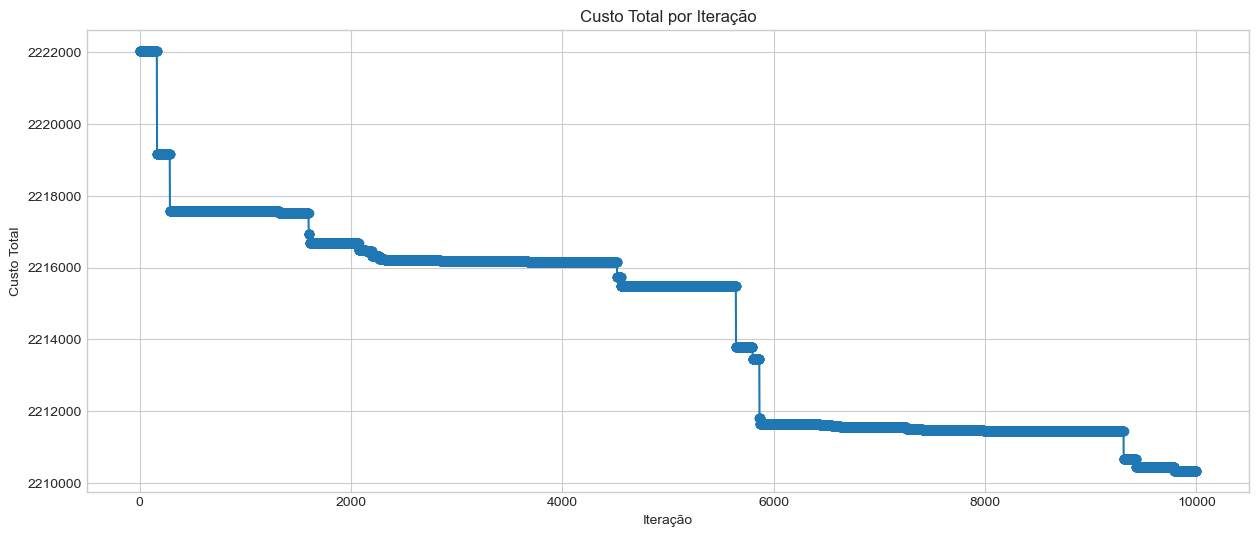

CPU times: total: 4h 26min 35s
Wall time: 5h 7min 53s


In [43]:
%%time
df_resultado_ils = ils(df_guloso_nova_term,df_nova_term,max_iteracoes_ils=10000,max_iteracoes_bl=100,mudancas_bl=10,n_mudancas=6,t_mudancas=1)

In [44]:
df_resultado_ils.custo.sum()

2210327.0

In [46]:
validador(df_resultado_ils,df_nova_term)
(df_resultado_ils.custo.sum()/df_guloso_nova_term.custo.sum()-1)*100

Solução validada!


-0.5266357909820218

In [213]:
df_term_david

,termica,limite_inferior,limite_superior,t_on,t_off,custo
0,g1,10,100,2,1,10
1,g2,10,100,5,1,20
2,g3,10,100,1,1,24


In [10]:
df_guloso_david

,g1,g2,g3,demanda_g1,demanda_g2,demanda_g3,tempo_ligada_g1,tempo_ligada_g2,tempo_ligada_g3,tempo_desligada_g1,tempo_desligada_g2,tempo_desligada_g3,tempo,demanda,custo
0,1,0,0,90.0,0,0,1,0,0,0,1,1,0,90.0,900.0
1,1,0,0,90.0,0,0,2,0,0,0,2,2,1,90.0,900.0
2,1,1,0,100,10.0,0,3,1,0,0,0,3,2,110.0,1200.0
3,1,1,0,80.0,10,0,4,2,0,0,0,4,3,90.0,1000.0
4,1,1,0,80.0,10,0,5,3,0,0,0,5,4,90.0,1000.0
5,1,1,0,80.0,10,0,6,4,0,0,0,6,5,90.0,1000.0
6,1,1,0,80.0,10,0,7,5,0,0,0,7,6,90.0,1000.0
7,1,0,0,90.0,0,0,8,0,0,0,1,8,7,90.0,900.0


In [9]:
%%time
df_term_david = pd.read_csv("df_term_david.csv")
demanda_david = np.loadtxt("demanda_david.csv")
df_guloso_david = termicas_guloso(df_term_david,demanda_david,size = len(demanda_david))
#df_guloso_david = df_guloso_david[0:8]

Térmica acionada:  g1 Demanda atual:  90.0 Demanda temp:  90.0 Tempo:  0 Custo:  900.0 Tempo acionada:  1
Térmica acionada (Obrigatória):  g1 Demanda atual:  90.0 Demanda temp:  10 Demanda Utilizada:  10 Tempo:  1 Custo:  100 Tempo acionada:  2
Térmica acionada:  g1 Demanda atual:  90.0 Demanda temp:  90.0 Demanda Utilizada:  80.0 Tempo:  1 Custo:  900.0 Tempo acionada:  2
Térmica acionada:  g1 Demanda atual:  110.0 Demanda temp:  100 Demanda Utilizada:  100 Tempo:  2 Custo:  1000 Tempo acionada:  3
Térmica acionada:  g2 Demanda atual:  110.0 Demanda temp:  110.0 Demanda Utilizada:  10.0 Tempo:  2 Custo:  1200.0 Tempo acionada:  1
Térmica acionada (Obrigatória):  g2 Demanda atual:  90.0 Demanda temp:  10 Demanda Utilizada:  10 Tempo:  3 Custo:  200 Tempo acionada:  2
Térmica acionada:  g1 Demanda atual:  90.0 Demanda temp:  90.0 Demanda Utilizada:  80.0 Tempo:  3 Custo:  1000.0 Tempo acionada:  4
Térmica acionada (Obrigatória):  g2 Demanda atual:  90.0 Demanda temp:  10 Demanda Utiliza

Custo atual:  7900.0
Não foi encontrado uma solução melhor!!!
Custo atual após primeira BL:  7900.0
Solução Viável encontrada
Solução viável encontrada após pertubação na iteração:  0
Não foi encontrado uma solução melhor!!!
Solucão não viável
Solução não viável após pertubação na iteração:  1
Solucão não viável
Solução não viável após pertubação na iteração:  2
Solucão não viável
Solução não viável após pertubação na iteração:  3
Solucão não viável
Solução não viável após pertubação na iteração:  4
Solucão não viável
Solução não viável após pertubação na iteração:  5
Solucão não viável
Solução não viável após pertubação na iteração:  6
Solucão não viável
Solução não viável após pertubação na iteração:  7
Solucão não viável
Solução não viável após pertubação na iteração:  8
Solucão não viável
Solução não viável após pertubação na iteração:  9
Solução Viável encontrada
Solução viável encontrada após pertubação na iteração:  10
Não foi encontrado uma solução melhor!!!
Solução Viável enco

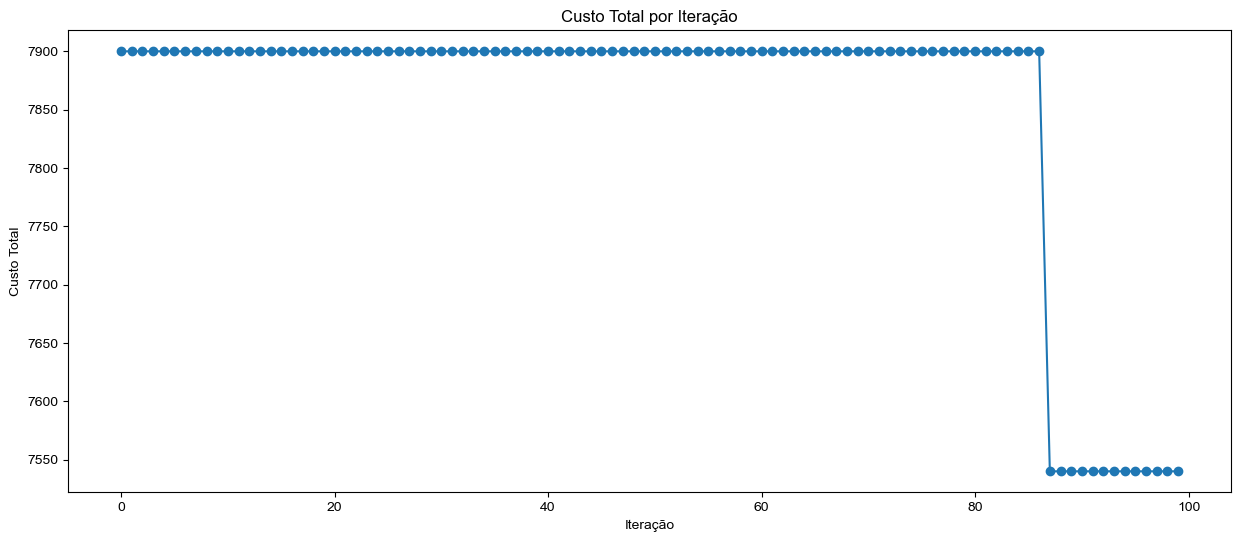

In [14]:
df_resultado_ils = ils(df_guloso_david,df_term_david,max_iteracoes_ils=100,max_iteracoes_bl=200,mudancas_bl=6,n_mudancas=2,t_mudancas=1)

In [59]:
df_resultado_ils.custo.sum()

7540.0

In [15]:
validador(df_resultado_ils,df_term_david)

Solução validada!


In [16]:
(df_resultado_ils.custo.sum()/df_guloso_david.custo.sum()-1)*100

-4.556962025316458

In [62]:
solucao_viavel(df_resultado_ils,df_term_david)

True

In [63]:
df_resultado_ils

,g1,g2,g3,demanda_g1,demanda_g2,demanda_g3,tempo_ligada_g1,tempo_ligada_g2,tempo_ligada_g3,tempo_desligada_g1,tempo_desligada_g2,tempo_desligada_g3,tempo,demanda,custo
0,1,0,0,90.0,0,0,1,0,0,0,1,1,0,90.0,900.0
1,1,0,0,90.0,0,0,2,0,0,0,2,2,1,90.0,900.0
2,1,0,1,100,0,10.0,3,0,1,0,3,0,2,110.0,1240.0
3,1,0,0,90.0,0,0,4,0,0,0,4,1,3,90.0,900.0
4,1,0,0,90.0,0,0,5,0,0,0,5,2,4,90.0,900.0
5,1,0,0,90.0,0,0,6,0,0,0,6,3,5,90.0,900.0
6,1,0,0,90.0,0,0,7,0,0,0,7,4,6,90.0,900.0
7,1,0,0,90.0,0,0,8,0,0,0,8,5,7,90.0,900.0


### Validação Solução

In [8]:
def validador(df_resultado,df_regras):
    
    termicas = list(df_regras.termica.unique())

    for tempo in range(len(df_resultado)):
        
        custo_tempo = df_resultado.iloc[tempo]['custo']
        demanda_tempo = df_resultado.iloc[tempo]['demanda']
        custo_termicas = 0
        demanda_termicas = 0
        
        for term in termicas:
            
            demanda_term = df_resultado.iloc[tempo][f'demanda_{term}']
            demanda_termicas = demanda_termicas + demanda_term
            custo_termicas = custo_termicas + (df_regras.loc[df_regras.termica==term]['custo'].iloc[0]*demanda_term)
            limite_superior_term = df_regras.loc[df_regras.termica==term]['limite_superior'].iloc[0]
            limite_inferior_term = df_regras.loc[df_regras.termica==term]['limite_inferior'].iloc[0]

            if df_resultado.iloc[tempo][term]==0 and demanda_term>0:
                return print("Solução errada no tempo: ",tempo," na térmica: ",term," térmica desligada com demanda associada")
            elif df_resultado.iloc[tempo][term]==1 and demanda_term==0:
                return print("Solução errada no tempo: ",tempo," na térmica: ",term," térmica ligada sem demanda associada")
            elif df_resultado.iloc[tempo][f'demanda_{term}'] > limite_superior_term:
                return print("Solução errada no tempo: ",tempo," na térmica: ",term," limite superior ultrapassado")
            elif df_resultado.iloc[tempo][f'demanda_{term}'] < limite_inferior_term and demanda_term!=0:
                return print("Solução errada no tempo: ",tempo," na térmica: ",term," limite inferior não atendido")

        if demanda_termicas!=demanda_tempo:
            return print("Solução errada no tempo: ",tempo," soma das demandas não bate com a coluna demanda")
        elif custo_termicas!=custo_tempo:
            return print("Solução errada no tempo: ",tempo," soma dos custos não bate com a coluna custo")

    return print("Solução validada!")

In [57]:
validador(df_guloso_nova_term,df_nova_term)

Solução validada!
